Package Imports

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt

Global Declarations

In [74]:
DATA = '../data/data.csv'
NEIGHBOURHOOD = []
ROOM_TYPE = []

Data Preprocessing

In [75]:
#read data from csv file
def read_data(file_name):
    data = pd.read_csv(file_name)
    return data 

In [76]:
def df_cleanup():
    
    df = pd.DataFrame(read_data(DATA))

    df = df.drop(df[df.availability_365 < 1].index)
    
    df = df.drop('license', axis=1)
    df = df.drop('last_review', axis=1)
    df = df.drop('reviews_per_month', axis=1)
    df = df.drop('calculated_host_listings_count', axis=1)
    df = df.drop('minimum_nights', axis=1)
    df = df.drop('number_of_reviews_ltm', axis=1)
    df = df.drop('name', axis=1)
    df = df.drop('host_name', axis=1)
    df = df.drop('availability_365', axis=1)

    df = df.replace('Studio', 0)
    df = df.replace('No rating', -1)
    df = df.replace('Not specified', -1)

    df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df['baths'] = pd.to_numeric(df['baths'], errors='coerce')

    df = df.replace('Manhattan', 1)
    df = df.replace('Queens', 2)
    df = df.replace('Staten Island', 3)
    df = df.replace('Brooklyn', 4)
    df = df.replace('Bronx', 5)

    for i in df['neighbourhood']:
        if i in NEIGHBOURHOOD:
            df = df.replace(i, NEIGHBOURHOOD.index(i))
        else:
            NEIGHBOURHOOD.append(i)
            df = df.replace(i, NEIGHBOURHOOD.index(i))
    
    room_type = []

    for i in df['room_type']:
        if i in ROOM_TYPE:
            df = df.replace(i, ROOM_TYPE.index(i))
        else:
            ROOM_TYPE.append(i)
            df = df.replace(i, ROOM_TYPE.index(i))

    df['neighbourhood_group'] = pd.to_numeric(df['neighbourhood_group'], errors='coerce')
    df['neighbourhood'] = pd.to_numeric(df['neighbourhood'], errors='coerce')
    df['room_type'] = pd.to_numeric(df['room_type'], errors='coerce')

    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df[df['price'] <= 1000]

    numerical_columns = df.select_dtypes(include='number')
    correlation_matrix = numerical_columns.corr()
    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.xticks(rotation = 25)
    plt.show()

    # print(df.head(), "before normalization")
    # df['price'] = MinMaxScaler(df[['price']])
    # df['rating'] = MinMaxScaler(df[['rating']])
    # df['number_of_reviews'] = MinMaxScaler(df[['number_of_reviews']])
    # df['bedrooms'] = MinMaxScaler(df[['bedrooms']])
    # df['beds'] = MinMaxScaler(df[['beds']])
    # df['baths'] = MinMaxScaler(df[['baths']])
    # df['latitude'] = MinMaxScaler(df[['latitude']])
    # df['longitude'] = MinMaxScaler(df[['longitude']])
    # print(df.head(), "after normalization")

    return df


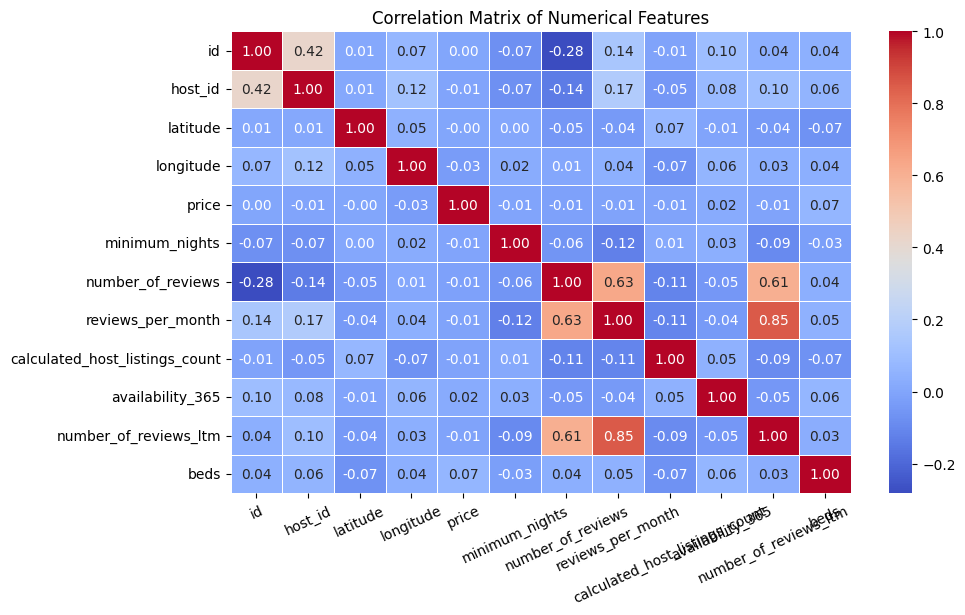

/var/folders/rq/91x5rw3560s1y0v50f_7jmz00000gn/T/ipykernel_64395/3999807156.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('Bronx', 5)
/var/folders/rq/91x5rw3560s1y0v50f_7jmz00000gn/T/ipykernel_64395/3999807156.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(i, NEIGHBOURHOOD.index(i))
/var/folders/rq/91x5rw3560s1y0v50f_7jmz00000gn/T/ipykernel_64395/3999807156.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old be

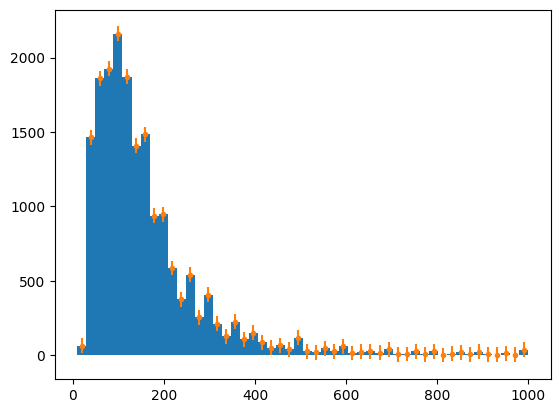

In [77]:
DF = df_cleanup()

hist, bin_edges = np.histogram(DF['price'], bins=50, density=False)
bin_center = (bin_edges[:-1] + bin_edges[1:])/2

plt.figure()
plt.hist(DF['price'], bins=50, density=False)
plt.errorbar(bin_center, hist, yerr=50, fmt='.')
plt.show()

In [78]:
print(DF.shape)
print(DF.dtypes)
print(ROOM_TYPE)
print(NEIGHBOURHOOD)
print(DF)

(17963, 22)
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                 int64
neighbourhood                       int64
latitude                          float64
longitude                         float64
room_type                           int64
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
rating                            float64
bedrooms                            int64
beds                                int64
baths                             float64
dtype: object
['Entire home/apt', 'Private room', 'Hotel room', 

In [79]:
#chech if there is entries with price > 3000
def check_price(df):
    if df[df['price'] > 3000].empty:
        print("No entries with price > 3000")
    else:
        print("There are entries with price > 3000")
        print(df[df['price'] > 3000])

check_price(DF)

No entries with price > 3000


In [80]:
X = DF.drop('price', axis = 1)
X = X.drop('id', axis = 1)

y = DF[['price']]

Scaler = preprocessing.MinMaxScaler()
X = Scaler.fit_transform(X)
X = pd.DataFrame(X, columns=DF.columns[2:])

print(DF.shape)
print(DF.dtypes)
print(DF)

ValueError: could not convert string to float: 'Rental unit in New York · ★4.67 · 2 bedrooms · 1 bed · 1 bath'

### Polynomial Regression

In [ ]:
# from sklearn.model_selection import kfold
pca = PCA(n_components=8)

poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(X)
poly_features = pca.fit_transform(poly_features)

# k = 5
# kf = kfold.KFold(n_splits=k, shuffle=True)

X_train,X_test, y_train, y_test = train_test_split(poly_features, y, test_size = 0.2)

reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(X_train, y_train)

print('Intercept: ',reg_model.intercept_)
list(zip(X, reg_model.coef_))

y_pred= reg_model.predict(X_test)  
x_pred= reg_model.predict(X_train)

y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred)

reg_model_diff = pd.DataFrame({'Actual value': y_test.iloc[:, 0], 'Predicted value': y_pred.iloc[:, 0]})
reg_model_diff.dropna(inplace=True)
print ("Model Score: ", reg_model.score(X_test, y_test))
print(np.sqrt(metrics.mean_squared_error(y_test,reg_model.predict(X_test))))
print(reg_model_diff)

Intercept:  [160.4510618]
Model Score:  0.29652818829347727
106.73606377091866
      Actual value  Predicted value
6            105.0        99.983758
9            292.0       181.643806
17           425.0       155.015360
35           188.0       160.111449
42            38.0       195.842206
...            ...              ...
3568         150.0       244.759839
3574          36.0       144.058238
3576          80.0       182.772199
3581          65.0       158.379395
3586          79.0       305.543815

[607 rows x 2 columns]


### SVM regression

In [ ]:
from sklearn import svm

regr = svm.SVR()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr.fit(X_train, y_train.values.ravel())

y_pred = regr.predict(X_test)

print('SVM model score: ', regr.score(X_test, y_test))
reg_model_diff = pd.DataFrame({'Predicted Value': y_pred, 'Actual Value': y_test.values.ravel()})
reg_model_diff.dropna(inplace=True)
print(reg_model_diff)

SVM model score:  0.17928126802823918
      Predicted Value  Actual Value
0          144.377891         285.0
1          126.035484         225.0
2          162.773865         120.0
3          131.364368         120.0
4          189.101824         208.0
...               ...           ...
3588       159.372119         180.0
3589       148.113816         190.0
3590       142.405153         300.0
3591       208.668421         550.0
3592       182.829990         113.0

[3593 rows x 2 columns]


In [ ]:
#evcaluation metrics
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2 score:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 14985.753526261313
Mean Absolute Error: 67.69873464451459
Root Mean Squared Error: 122.41631233729153
R^2 score: 0.17928126802823918


Correlation Matrix

In [ ]:
# numerical_columns = DF.select_dtypes(include='number')
# correlation_matrix = numerical_columns.corr()
# # Heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title('Correlation Matrix of Numerical Features')
# plt.xticks(rotation = 25)
# plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.scatter(reg_model_diff.iloc[:, 0], reg_model_diff.iloc[:, 1])
# plt.title("Price Predict")
# plt.xlabel('Actual Value')
# plt.ylabel('Predicted Value')
# plt.show()

Artificial Neural Network

In [81]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X = DF.drop('price', axis = 1)
X = X.drop('id', axis = 1)

y = DF[['price']].values.reshape(-1,)

Scaler = preprocessing.MinMaxScaler()
X = Scaler.fit_transform(X)
X = pd.DataFrame(X, columns=DF.columns[2:])

# pca = PCA(n_components=8)
# X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
regr = MLPRegressor(max_iter=1800,
                          activation='tanh', 
                          hidden_layer_sizes={50,50,25},
                          early_stopping=True,
                          n_iter_no_change=1800,
                          verbose=True,
                          learning_rate='invscaling',
                          learning_rate_init=.001).fit(X_train, y_train)
print(regr.score(X_test, y_test))

ValueError: could not convert string to float: 'Rental unit in New York · ★4.67 · 2 bedrooms · 1 bed · 1 bath'

      Prediction  Actual
0     103.392851    69.0
1     239.896199   172.0
2     378.345838   477.0
3      77.134998   128.0
4     145.833118   145.0
...          ...     ...
3588  158.514464   150.0
3589  201.161955   250.0
3590  227.435337   167.0
3591   67.489442    85.0
3592   86.050585    93.0

[3593 rows x 2 columns]
Error: 99.3109142012318
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
0    778
dtype: int64
0    0.496741
dtype: float64


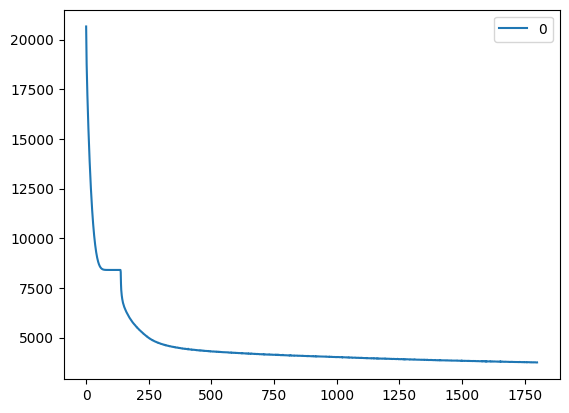

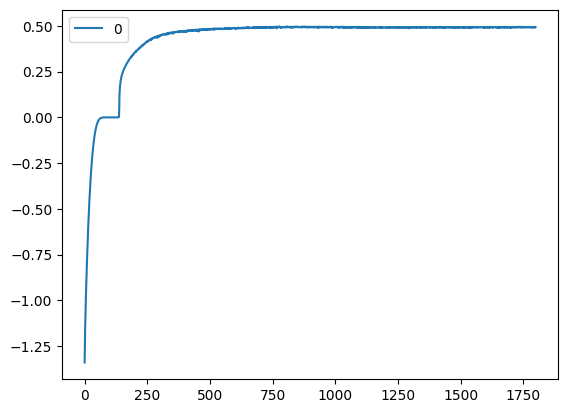

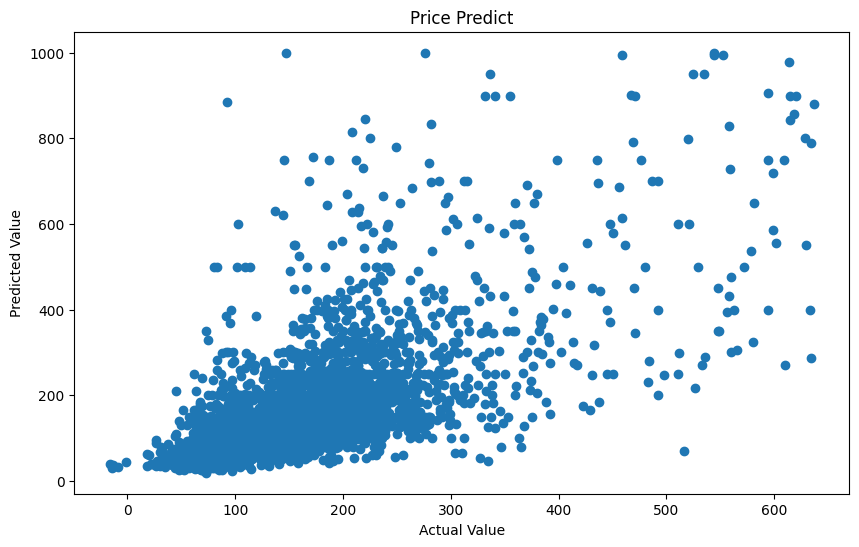

In [ ]:
DFT = pd.DataFrame({'Prediction':regr.predict(X_test),'Actual': y_test})
print(DFT)
print('Error:', np.sqrt(metrics.mean_squared_error(y_test,regr.predict(X_test))))
print(pd.DataFrame(regr.loss_curve_).plot())
print(pd.DataFrame(regr.validation_scores_).plot())
print(pd.DataFrame(regr.validation_scores_).idxmax())
print(pd.DataFrame(regr.validation_scores_).max())
# print(regr.best_validation_score_)

plt.figure(figsize=(10, 6))
plt.scatter(DFT.iloc[:, 0], DFT.iloc[:, 1])
plt.title("Price Predict")
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()